# Logistic Regression and Classification Error Metrics
![LogRegr.png](Assets/LogRegr.png)


# Learning Objectives

- Describe Logistic regression and how it differs from linear regression
- Identify metrics for classification errors and scenarios in which they can be used
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware


# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
data_path = ['../resources']

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [4]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = 'resources/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [5]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [6]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [8]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [9]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

5823    4
6249    2
1495    2
5234    4
1031    1
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [11]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

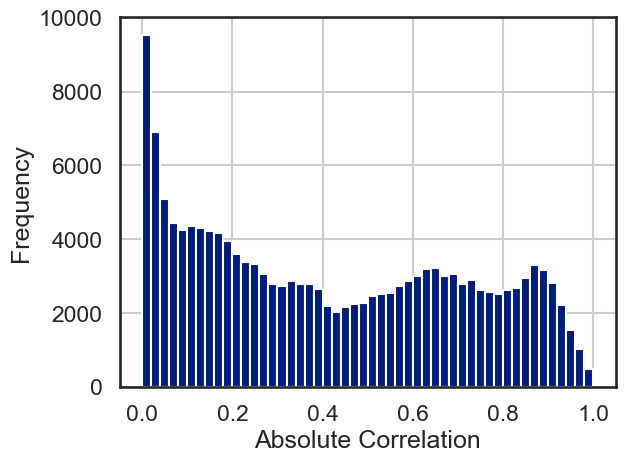

In [13]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [14]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [16]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [18]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(C=.001, max_iter=295).fit(X_train, y_train)

In [19]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [20]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [21]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=1, cv=4, penalty='l2').fit(X_train, y_train)

C:\Users\soura\venv\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:629: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [22]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
198  0.008397  0.019704 -0.027727  0.036343  0.001668 -0.038384  0.0   
144 -0.018566 -0.003544 -0.033353  0.037829  0.002407  0.015227  0.0   
233 -0.013475 -0.019567 -0.022490  0.036769  0.044794 -0.026030  0.0   
374  0.017919 -0.015183  0.027891  0.017873  0.009714 -0.058214  0.0   
415 -0.002297 -0.003201 -0.003723  0.006498  0.016407 -0.013684  0.0   
53   0.117523  0.044408 -0.130435  0.002498  0.018171 -0.052165  0.0   
80   0.002594 -0.000203 -0.001090  0.000847  0.002142 -0.004290  0.0   
265 -0.013845 -0.026460 -0.031248 -0.017851  0.068490  0.020914  0.0   
289 -0.030843 -0.025208 -0.044491  0.049947  0.037344  0.013252  0.0   
87  -0.019523 -0.028035 -0.029559  0.068661  0.006354  0.002102  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
198  0.113143 -0.417956  4.710755  2.354146 -6.004426  0.004297  0.003073   
144  0.000000  0.026172  0.940228  0.451110  0.000000 -0.009993 -0.008021   
233  0.000000  0.000000  0.887368  1.729183 -1.917752 -0.008200 -0.009263   
374 -1.249573  1.115173  1.742940  1.424480 -2.334300  0.008727  0.002394   
415  0.000000  0.000000 -0.080127  0.619955  0.000000 -0.001637 -0.001745   
53   2.531622 -7.825492  1.192850  0.520076 -1.322720  0.044577  0.002323   
80   0.000000  0.000000  0.000000 -1.187713 -1.365489  0.000522 -0.000052   
265 -0.564331  0.000000 -0.505679  0.656418  1.506991 -0.009528 -0.012062   
289  0.000000 -0.150822  0.000000  1.394125 -0.096601 -0.018012 -0.016822   
87   0.000000 -0.226105  1.025294 -0.870249  0.000000 -0.011349 -0.012668   

                                             
            2         3         4         5  
198 -0.006516  0.004454 -0.000065 -0.005243  
144 -0.010808  0.013516  0.005411  0.009894  
233 -0.010231  0.012839  0.016780 -0.001926  
374  0.005454  0.000041  0.001169 -0.017785  
415 -0.001984  0.002378  0.005573 -0.002584  
53  -0.028821 -0.004378  0.000147 -0.013848  
80  -0.000249 -0.000093  0.000434 -0.000562  
265 -0.013694  0.003181  0.024054  0.008048  
289 -0.017946  0.021204  0.017802  0.013775  
87  -0.013580  0.021749  0.011865  0.003983

Prepare six separate plots for each of the multi-class coefficients.

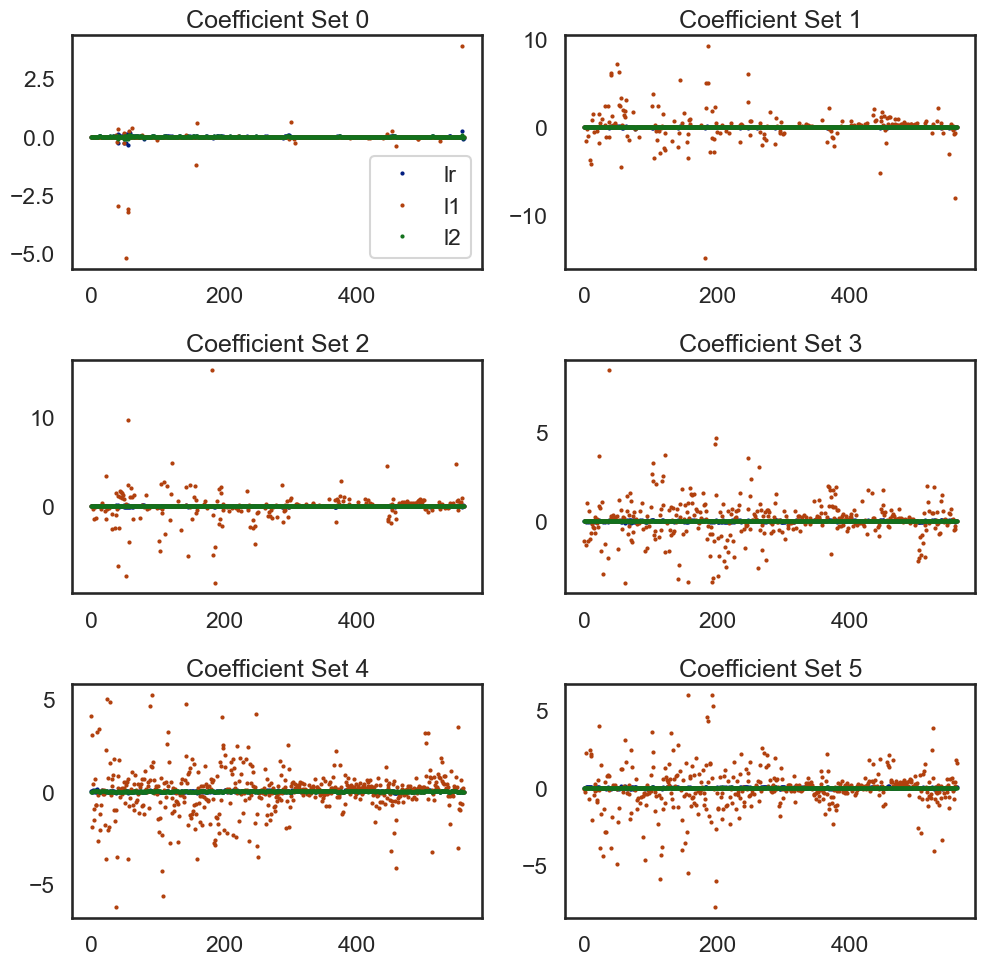

In [23]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [24]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


C:\Users\soura\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [25]:
y_prob.head()

,lr,l1,l2
0,0.733037,0.998909,0.344193
1,0.510313,0.999718,0.313596
2,0.561760,0.995806,0.305891
3,0.537524,0.999193,0.333243
4,0.822264,0.999919,0.486693


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [27]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.911089,0.984153,0.866900
recall,0.910356,0.984142,0.852427
fscore,0.909827,0.984140,0.845593
accuracy,0.910356,0.984142,0.852427
auc,0.945884,0.990342,0.910622


## Question 8

Display or plot the confusion matrix for each model.

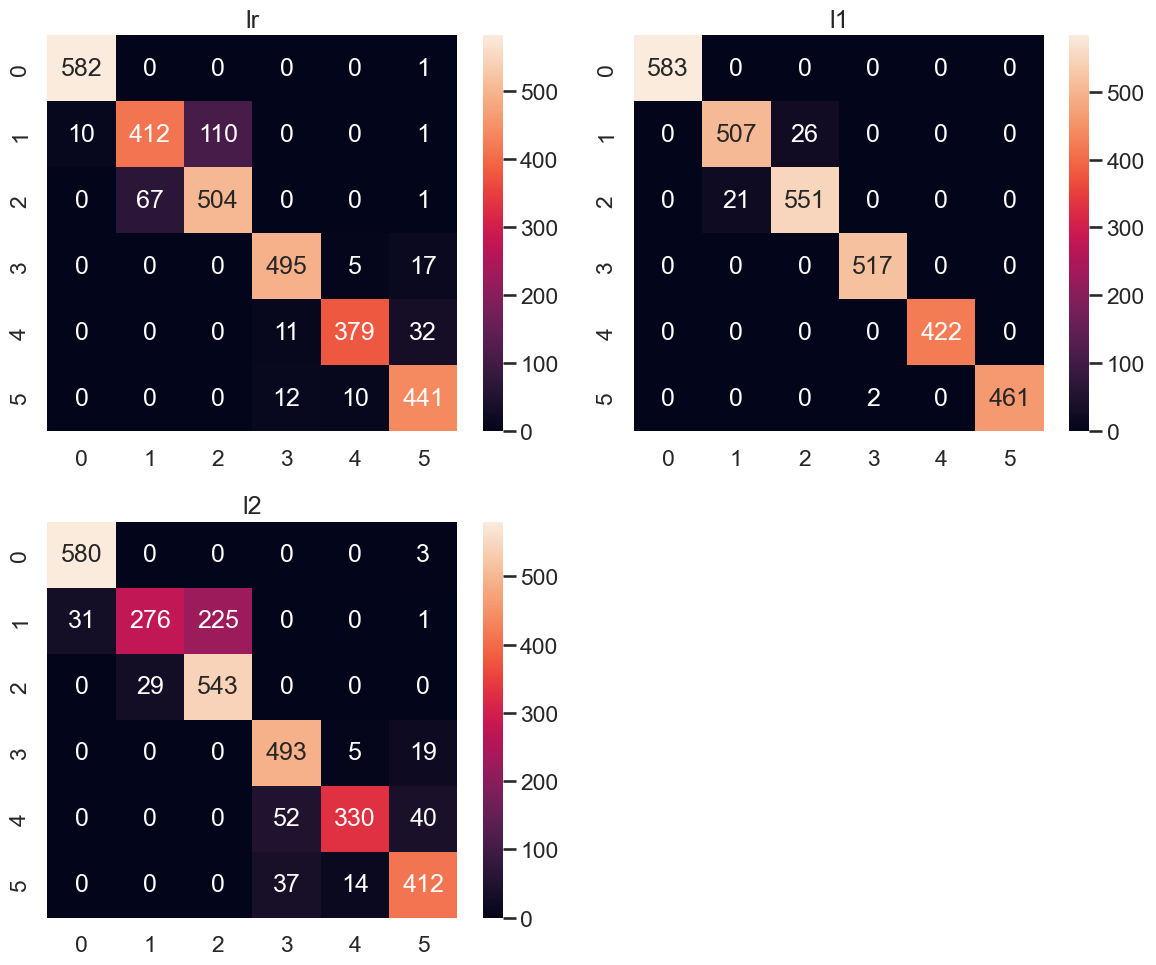

In [28]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [ ]:
# Try standard, L1 and L2 Logistic regression

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [ ]:
# Combine all the coefficients into a dataframe for comparison


Prepare six separate plots for each of the multi-class coefficients.

In [ ]:
# try the plots

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [ ]:
# Predict the class and the probability for each


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
# Calculate the error metrics as listed above

In [ ]:
#Run the metrics

## Question 13

Display or plot the confusion matrix for each model.

In [ ]:
#plot the confusion matrix

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation